In [2]:
from utils_ConConCor import *
from utils_SABIO import *
from utils_nlp import *

import numpy as np
import numpy.random as rand

from collections import Counter, defaultdict

import os

2022-09-07 12:37:06.876599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 12:37:06.876623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-07 12:37:09.194557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 12:37:09.194587: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 12:37:09.194607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valentin-hp): /proc/driver/nvidia/version does not exist


In [13]:
ccc = get_CCC_DF()
ccc_terms = ccc.target.unique()

nmvw = get_NMvW_DF().sort_index()
nmvw["Segmented"] = pd.read_csv("nmvw_segmented2.csv").set_index("ID").Texts.fillna("")

sabio_scores = pd.read_csv("SABIO_scores_10_08_2022.csv").set_index("id")
sabio_scores = sabio_scores.drop("VocabularyEnginev0", axis=1)

In [8]:
sabio_scores.columns

Index(['ContentLengthEnginev0', 'VocabularyEnginev0', 'TypicalityEnginev0',
       'RandomEnginev0', 'PMIEnginev0'],
      dtype='object')

In [4]:
txts = nmvw.Texts


found, forms = find_lemmata(ccc_terms, txts, 
                     parallel=True, only_whole_words=True, return_forms=True)

getting wordforms from INT (internet up?): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:10<00:00,  8.97it/s]


Pandas Apply:   0%|          | 0/146694 [00:00<?, ?it/s]

In [5]:
def subset(scores, found_list):
    def get_k(k):
        return scores[(found_list.apply(len) >= k)]
    return get_k
    
def get_samples_k(scores, found_list, k):
    n = len(scores)
    samples = scores[(found_list.apply(len) > k)]
    return samples.sample(min(3000, len(samples)))

def get_means_k(scores, found_list, ks):
    return np.asarray([get_samples_k(scores, found_list, k).mean() for k in ks])

---
## SUBSET SIZES

0	1	2	3	4	5	6	7	8	9
146694	16618	5491	2980	1799	1231	891	710	647	586	556	503	448	426	347


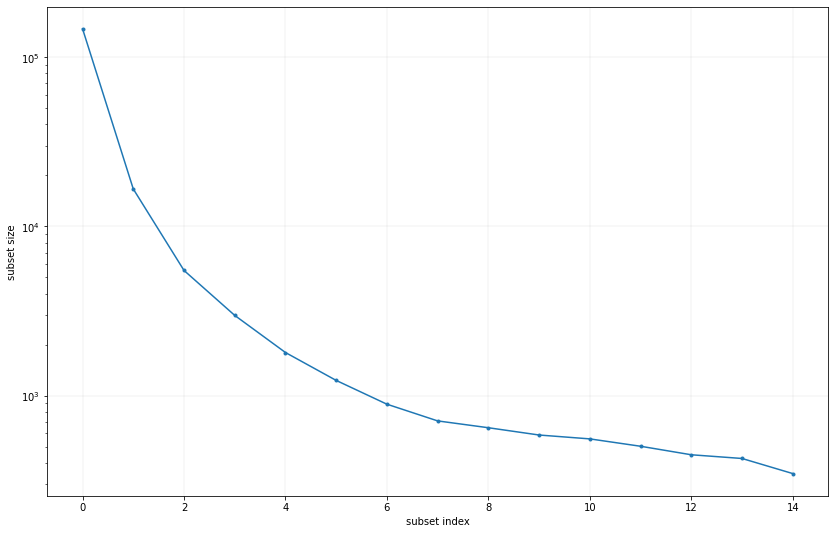

In [17]:
get_subset = subset(sabio_scores, found)
subsets = [get_subset(i) for i in range(15)]

plt.figure(figsize=(14, 9))
plt.plot(list(map(len, subsets)), ".-")
plt.yscale("log")
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.2)
plt.xlabel("subset index")
plt.ylabel("subset size")

# plt.savefig("../plots/subset_sizes.png", dpi=300)

print("\t".join(map(str, range(10))))
print("\t".join(map(lambda ls: str(len(ls)), subsets)))

In [ ]:
ks = range(9)
overlaps = []

for engine in sabio_scores.columns:
    sample_ls = [get_samples_k(sabio_scores[engine], found, i)for i in ks]
    

In [31]:
sabio_scores.columns

Index(['ContentLengthEnginev0', 'TypicalityEnginev0', 'RandomEnginev0',
       'PMIEnginev0'],
      dtype='object')

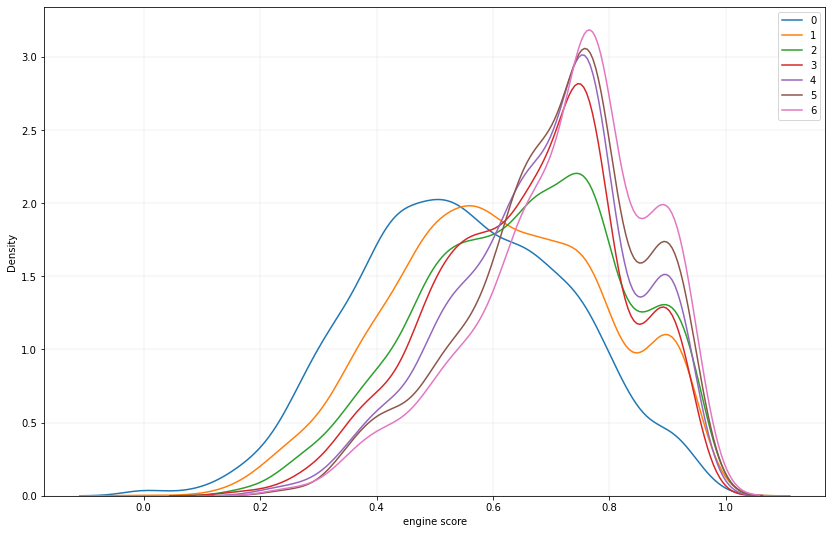

In [40]:
engine = "TypicalityEnginev0"
sample_ls = [get_samples_k(sabio_scores[engine], found, i)for i in rng]
    
plt.figure(figsize=(14, 9))

for i, s in enumerate(sample_ls):
    sns.kdeplot(s, label=str(i))
    
plt.xlabel("density")
plt.xlabel("engine score")
plt.legend()
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.2)

---
## TRENDS - Significance of Trends

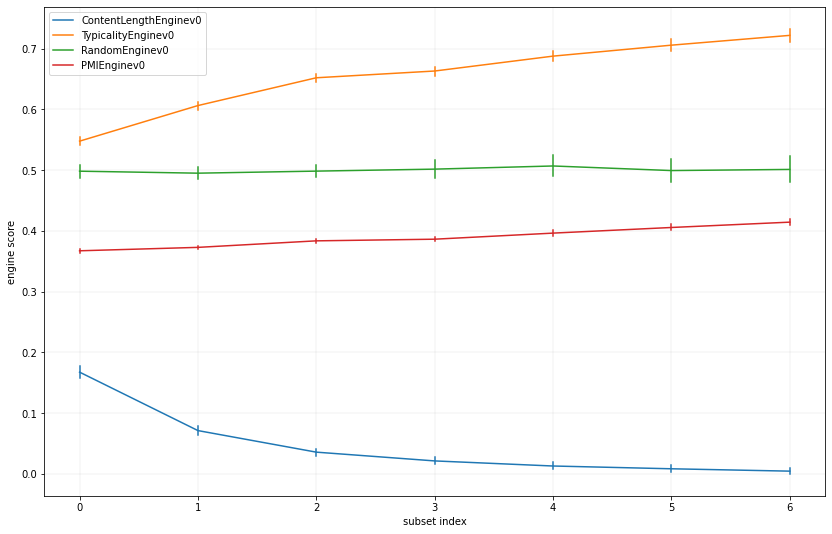

In [39]:
get_subset = subset(sabio_scores, found)

rng = range(7)

plt.figure(figsize=(14, 9))


for e in sabio_scores.columns:
    subsets = [get_subset(i)[e] for i in rng]
    
    dist_df = [(v, k) for k in rng for v in get_samples_k(sabio_scores[e], found, k)]
    dist_df = pd.DataFrame(dist_df, columns=["v", "k"])
    
    sns.lineplot(data=dist_df, x="k", y="v", err_style="bars", label=e)

    

#     means = [s.mean() for s in subsets]
#     stds = [s.var()**0.5 for s in subsets]
#     plt.plot(means, ".-", label=e)
#     plt.ylim((0., 1.0))

plt.xlabel("subset index")
plt.ylabel("engine score")
plt.legend()
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.2)

ContentLengthEnginev0
Mann_Kendall_Test(trend='decreasing', h=True, p=8.303070332638107e-05, z=-3.9354796403996297, Tau=-1.0, s=-45.0, var_s=125.0, slope=-0.013841442565427164, intercept=0.07893009917191093)


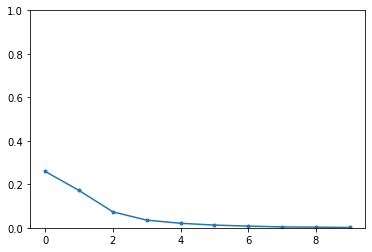


TypicalityEnginev0
Mann_Kendall_Test(trend='increasing', h=True, p=8.303070332638107e-05, z=3.9354796403996297, Tau=1.0, s=45.0, var_s=125.0, slope=0.022804493509776314, intercept=0.5730257401130725)


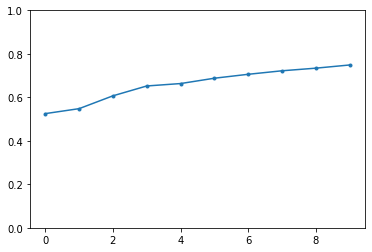


RandomEnginev0
Mann_Kendall_Test(trend='no trend', h=False, p=0.4742743507673295, z=0.7155417527999327, Tau=0.2, s=9.0, var_s=125.0, slope=0.0002553408004436645, intercept=0.498887298271912)


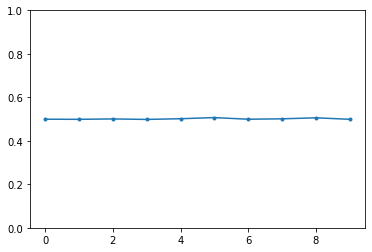


PMIEnginev0
Mann_Kendall_Test(trend='increasing', h=True, p=0.00017224145338756713, z=3.7565942021996466, Tau=0.9555555555555556, s=43.0, var_s=125.0, slope=0.0068775188262944565, intercept=0.3602856867619269)


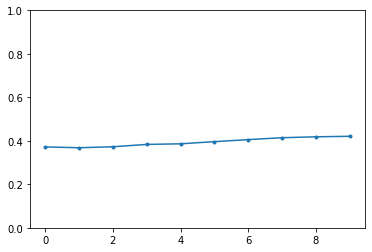

In [24]:
# engine = "PMIEnginev0"
from scipy.stats import ttest_ind
import pymannkendall as mk


get_subset = subset(sabio_scores, found)

for e in sabio_scores.columns:
    subsets = [get_subset(i)[e] for i in range(10)]


    x, y = subsets[0], subsets[1]

    means = [s.mean() for s in subsets]
    stds = [s.var()**0.5 for s in subsets]

    print(e)
    print(mk.original_test(means))

    plt.plot(means, ".-")
    plt.ylim((0., 1.0))
    plt.show()
#     print(mk.original_test(stds))
    print()

---
# TRENDS - Overlaps

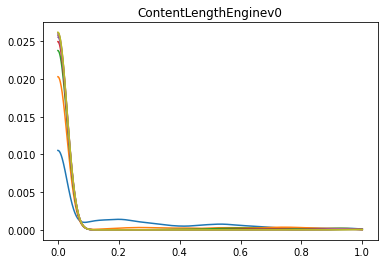

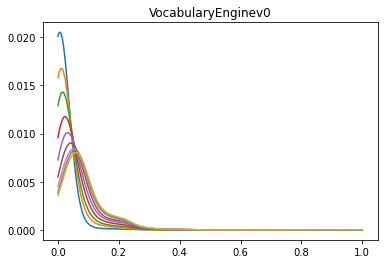

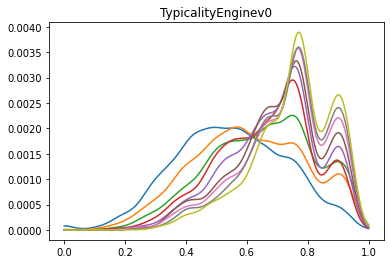

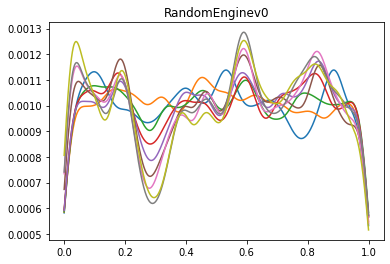

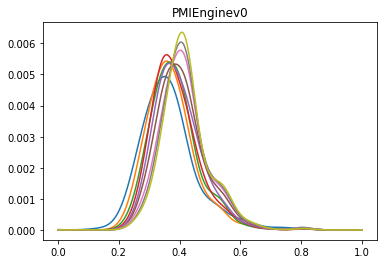

In [22]:
# engine = "PMIEnginev0"


from sklearn.neighbors import KernelDensity
from scipy.stats import entropy


ks = range(9)
overlaps = []

for engine in sabio_scores.columns:
    sample_ls = [get_samples_k(sabio_scores[engine], found, i)for i in ks]
    # 0.02
    kdes = [KernelDensity(kernel='gaussian', bandwidth=0.03).fit(samples.values.reshape((-1, 1)))
            for samples in sample_ls]

    rng = np.linspace(0., 1., 1000)
    epsilon = 1e-10
    probs = [np.exp(cur_kde.score_samples(rng.reshape((-1, 1)))) + epsilon for cur_kde in kdes]
    normed_ps = [p/p.sum() for p in probs]

    for p in normed_ps:
        plt.plot(rng, p)
    plt.title(engine)
    plt.show()
    
    
    
    jacc = lambda p, q: sum((p*q)/(p+q)) # - p*q)
    
    cur_ovl = np.asarray([jacc(normed_ps[0], p) for p in probs])
    cur_ovl = np.asarray([jacc(p1, p2) for p1. p2 in zip(probs[:-1], probs[1:]))
    
#     cur_ovl = np.asarray([1-entropy(probs[0], p) for p in probs])
#     cur_ovl = 
    overlaps.append(cur_ovl)
overlaps = np.asarray(overlaps)


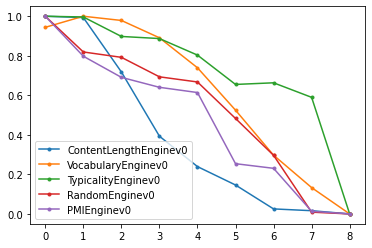

In [24]:
for o, c in zip(overlaps, sabio_scores.columns):
    o = (o - o.min())/(o.max() - o.min())
    plt.plot(ks, o, ".-", label=c)
plt.legend()
# plt.ylim((0.98, 1))

---
# Random Word Lists

In [25]:
all_counts = Counter(w for txt in txts for w in txt.split() if len(w) > 1)

def draw_rand(terms, counts, plusminus=5):
    freq_groups = defaultdict(list)
    for w, c in counts.items():
        freq_groups[c].append(w)
        
    rand_terms = []
    for w in terms:
        cur_c = counts[w]
        if cur_c > 0:
            cur_choices = [ls for c_ in range(cur_c-plusminus, cur_c+plusminus) 
                             for ls in freq_groups[c_]]
            rand_terms.append(rand.choice(cur_choices))
    return rand_terms

In [26]:
sum([all_counts[w] for w in draw_rand(ccc_terms, all_counts)])

17393

In [27]:
sum([all_counts[w] for w in ccc_terms])

17437

In [28]:
rs, fs = list(zip(*[(r, f) for r, (w, f) in enumerate(all_counts.most_common(), 1)]))

ccc_zipf = [(r, f, w) for r, (w, f) in enumerate(all_counts.most_common(), 1)
                           if w in forms]

In [29]:
rnd = draw_rand(ccc_terms, all_counts, plusminus=100)
rand_found, rand_forms = find_lemmata(rnd, txts, 
                     parallel=True, only_whole_words=True, return_forms=True)

getting wordforms from INT (internet up?): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:47<00:00,  1.39it/s]


Pandas Apply:   0%|          | 0/146694 [00:00<?, ?it/s]

In [30]:
rand_zipf = [(r, f, w) for r, (w, f) in enumerate(all_counts.most_common(), 1)
                           if w in rand_forms]

In [ ]:
plt.figure(figsize=(14, 9))
plt.plot(rs, fs, ".")

for i, (ccc_r, ccc_f, ccc_w) in enumerate(ccc_zipf):
    plt.plot(ccc_r, ccc_f, ".", c="r", ms=15)
    if i % 5 == 0:
        plt.annotate(ccc_w, (ccc_r, ccc_f))
    
plt.xscale("log"); plt.yscale("log")

plt.show()

plt.figure(figsize=(14, 9))
plt.plot(rs, fs, ".")

for i, (ccc_r, ccc_f, ccc_w) in enumerate(rand_zipf):
    plt.plot(ccc_r, ccc_f, ".", c="r", ms=15)
    if i % 5 == 0:
        plt.annotate(ccc_w, (ccc_r, ccc_f))
    
plt.xscale("log"); plt.yscale("log")

In [31]:
sum([all_counts[w] for w in forms]), sum([all_counts[w] for w in rand_forms])

(27894, 27728)

In [32]:
found.apply(len).sum(), rand_found.apply(len).sum()

(37278, 17858344)

In [33]:
set(ccc_terms) & set(rnd)

set()

ContentLengthEnginev0
Mann_Kendall_Test(trend='increasing', h=True, p=0.00020565595274235626, z=3.7119655877432596, Tau=0.9333333333333333, s=42.0, var_s=122.0, slope=0.0018517801671300755, intercept=0.2547316248149222)

VocabularyEnginev0
Mann_Kendall_Test(trend='increasing', h=True, p=0.00020565595274235626, z=3.7119655877432596, Tau=0.9333333333333333, s=42.0, var_s=122.0, slope=1.8734047754027797e-05, intercept=0.00217105677168031)

TypicalityEnginev0
Mann_Kendall_Test(trend='increasing', h=True, p=0.0008086333048040739, z=3.3498226035731857, Tau=0.8444444444444444, s=38.0, var_s=122.0, slope=0.0012965751051611796, intercept=0.5224249397648395)

RandomEnginev0
Mann_Kendall_Test(trend='no trend', h=False, p=0.5262438434591223, z=0.6337502222976297, Tau=0.17777777777777778, s=8.0, var_s=122.0, slope=6.768727623766383e-07, intercept=0.49939980923384664)

PMIEnginev0
Mann_Kendall_Test(trend='increasing', h=True, p=0.03731305320219125, z=2.082322158977926, Tau=0.5333333333333333, s=24.0

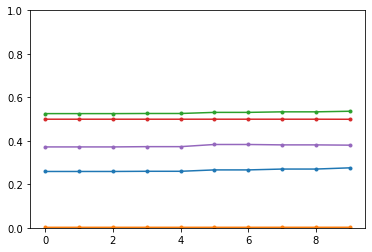

In [34]:
# engine = "PMIEnginev0"
from scipy.stats import ttest_ind
import pymannkendall as mk


get_subset = subset(sabio_scores, rand_found)

for e in sabio_scores.columns:
    subsets = [get_subset(i)[e] for i in range(10)]


    x, y = subsets[0], subsets[1]

    means = [s.mean() for s in subsets]
    stds = [s.var()**0.5 for s in subsets]

    print(e)
    print(mk.original_test(means))

    plt.plot(means, ".-")
    plt.ylim((0., 1.0))
#     plt.show()
#     print(mk.original_test(stds))
    print()

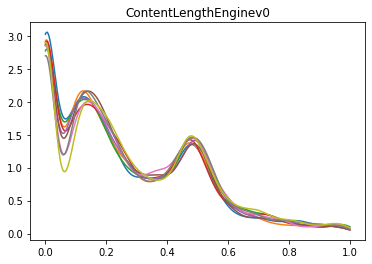

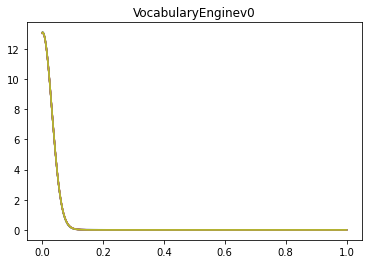

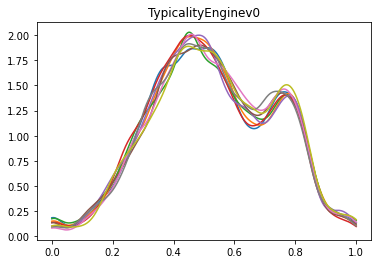

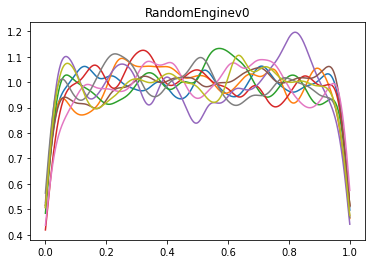

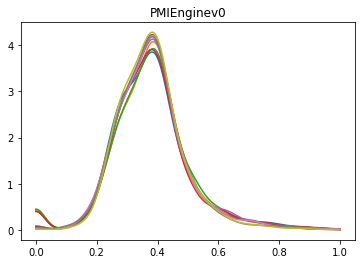

In [35]:
# engine = "PMIEnginev0"


from sklearn.neighbors import KernelDensity
from scipy.stats import entropy


ks = range(9)
overlaps = []

for engine in sabio_scores.columns:
    sample_ls = [get_samples_k(sabio_scores[engine], rand_found, i) for i in ks]
    # 0.02
    kdes = [KernelDensity(kernel='gaussian', bandwidth=0.03).fit(samples.values.reshape((-1, 1)))
            for samples in sample_ls]

    rng = np.linspace(0., 1., 1000)
    epsilon = 1e-10
    probs = [np.exp(cur_kde.score_samples(rng.reshape((-1, 1)))) + epsilon for cur_kde in kdes]
    
    for p in probs:
        plt.plot(rng, p)
    plt.title(engine)
    plt.show()
    
    cur_ovl = np.asarray([1-entropy(probs[0], p) for p in probs])
#     cur_ovl = 
    overlaps.append(cur_ovl)
overlaps = np.asarray(overlaps)


---
## Draw Lots of Random Lists

In [ ]:
# DO NOT RE-RUN

for i in tqdm(range(100)):
    rnd = draw_rand(ccc_terms, all_counts, plusminus=100)
    rand_found, rand_forms = find_lemmata(rnd, txts, 
                         parallel=True, only_whole_words=True, return_forms=True)

    rand_found.to_csv(f"random_found_unsegmented/{i}.csv", index=True)

---

In [38]:
rand_founds = [pd.read_csv(f"random_found/{file}").set_index("ID")
               for file in tqdm(os.listdir("random_found"))]

rand_founds = pd.concat(rand_founds, axis=1).progress_applymap(eval)
rand_founds.columns = list(range(len(rand_founds.columns)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.61it/s]


Pandas Apply:   0%|          | 0/14669400 [00:00<?, ?it/s]

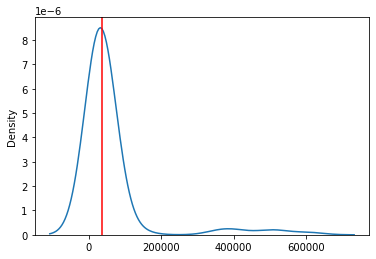

In [41]:
sns.kdeplot(rand_founds.applymap(len).sum(axis=0))
plt.axvline(found.apply(len).sum(), c="r")

In [42]:
num_ccc_hits = found.apply(len).sum()
subset = rand_founds.applymap(len).sum(axis=0).between(num_ccc_hits-(num_ccc_hits*0.3),
                                                      num_ccc_hits+(num_ccc_hits*0.3))

correct_length_subset = rand_founds[list(subset[subset].index)]

In [43]:
correct_length_subset

,0,1,3,6,7,8,9,10,11,12,...,87,88,90,92,93,94,95,97,98,99
ID,,,,,,,,,,,,,,,,,,,,,
2,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[mand],[],[],[],[],[],[]
5,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
8,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[mand],[],[],[],[],[],[]
9,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
10,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153236,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
1153448,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[b.],[]
1153691,[],[],[],[grondgebied],[],[sinds],[],[],[],[],...,[],[],[sinds],[],[],[],[],[],[],[]


---
## Extract Trends

In [44]:
def subset(scores, found_list):
    def get_k(k):
        return scores[(found_list.apply(len) > k)]
    return get_k
    
def get_samples_k(scores, found_list, k):
    n = len(scores)
    samples = scores[(found_list.apply(len) > k)]
#     print(min(10000, len(samples)))
    return samples.sample(min(500, len(samples)))

def get_means_k(scores, found_list, ks, with_stds=True):
    score_dists = [get_samples_k(scores, found_list, k) for k in ks]
    means = np.asarray([dist.mean() for dist in score_dists])
    
    if with_stds:
        return means, np.asarray([dist.var()**.5 for dist in score_dists])
    return means

In [45]:
%matplotlib qt
engine = "TypicalityEnginev0"
rng = range(1, 7)
means, cur_stds = get_means_k(sabio_scores[engine], found, rng)

plt.figure(figsize=(15, 10))


for c in tqdm(rand_founds.columns):
    cur_means, cur_stds = get_means_k(sabio_scores[engine], rand_founds[c], rng)
    if np.max(cur_means) > np.max(means):
        continue
    found_forms = {w for ls in rand_founds[c] for w in ls}
    plt.plot(cur_means, ".-", label=f"{c}, {len(found_forms)}, {rand_founds[c].apply(len).sum()}")

plt.plot(means, "o-", c="r", label=f"CCC, {len(forms)}, {found.apply(len).sum()}", ms=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim((0., 1.0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


(0.0, 1.0)

In [ ]:
%matplotlib qt
engine = "TypicalityEnginev0"
rng = range(1, 7)
means, cur_stds = get_means_k(sabio_scores[engine], found, rng)

plt.figure(figsize=(15, 10))


for c in tqdm(rand_founds.columns):
    cur_means, cur_stds = get_means_k(sabio_scores[engine], rand_founds[c], rng)
    if np.max(cur_means) > np.max(means):
        continue
    found_forms = {w for ls in rand_founds[c] for w in ls}
    plt.plot(cur_means, ".-", label=f"{c}, {len(found_forms)}, {rand_founds[c].apply(len).sum()}")

plt.plot(means, "o-", c="r", label=f"CCC, {len(forms)}, {found.apply(len).sum()}", ms=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim((0., 1.0))

In [52]:


for c in tqdm(rand_founds.columns):
    cur_means, cur_stds = get_means_k(sabio_scores[engine], rand_founds[c], rng)
    print(mk.original_test(cur_means))
    

  2%|████                                                                                                                                                                                                     | 2/100 [00:00<00:18,  5.23it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.00930800000000001, intercept=0.394722)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=0.3757345746510897, Tau=0.2, s=3.0, var_s=28.333333333333332, slope=0.0012726666666666813, intercept=0.3903473333333333)


  4%|████████                                                                                                                                                                                                 | 4/100 [00:00<00:17,  5.60it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.004865000000000008, intercept=0.39301649999999994)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.007142666666666686, intercept=0.3618133333333333)


  6%|████████████                                                                                                                                                                                             | 6/100 [00:01<00:17,  5.43it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.011481000000000019, intercept=0.3638204999999999)
Mann_Kendall_Test(trend='no trend', h=False, p=0.13285495573105388, z=1.502938298604359, Tau=0.6, s=9.0, var_s=28.333333333333332, slope=0.001564999999999983, intercept=0.36151450000000007)


  7%|██████████████                                                                                                                                                                                           | 7/100 [00:01<00:16,  5.49it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.005532, intercept=0.3806988412698412)


  9%|██████████████████                                                                                                                                                                                       | 9/100 [00:01<00:17,  5.07it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.010028666666666667, intercept=0.3430823333333334)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.012823999999999983, intercept=0.40078600000000003)


 11%|██████████████████████                                                                                                                                                                                  | 11/100 [00:02<00:16,  5.35it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.014813000681663246, intercept=0.36187349829584187)
Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.0035430000000000184, intercept=0.37061749999999993)


 13%|██████████████████████████                                                                                                                                                                              | 13/100 [00:02<00:15,  5.58it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.011287999999999965, intercept=0.3671570000000001)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.005580000000000029, intercept=0.364264)


 15%|██████████████████████████████                                                                                                                                                                          | 15/100 [00:02<00:14,  5.71it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.010726999999999987, intercept=0.3924225000000001)
Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.004556000000000032, intercept=0.379264)


 17%|██████████████████████████████████                                                                                                                                                                      | 17/100 [00:03<00:14,  5.73it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.0051169999999999966, intercept=0.3988245)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=0.3757345746510897, Tau=0.2, s=3.0, var_s=28.333333333333332, slope=0.002578461139896404, intercept=0.38000530829015533)


 19%|██████████████████████████████████████                                                                                                                                                                  | 19/100 [00:03<00:14,  5.70it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.010681977235772355, intercept=0.3952280569105691)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.009020955390334567, intercept=0.3674806115241636)


 21%|██████████████████████████████████████████                                                                                                                                                              | 21/100 [00:03<00:15,  5.09it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=0.3757345746510897, Tau=0.2, s=3.0, var_s=28.333333333333332, slope=0.0017839068627450994, intercept=0.38295065866827155)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.010834666666666649, intercept=0.36013833333333345)


 23%|██████████████████████████████████████████████                                                                                                                                                          | 23/100 [00:04<00:14,  5.37it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.002619867889908256, intercept=0.3695619510703364)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.0028120000000000367, intercept=0.3652169999999999)


 25%|██████████████████████████████████████████████████                                                                                                                                                      | 25/100 [00:04<00:13,  5.56it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.00562600000000002, intercept=0.38311599999999996)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.009594666666666677, intercept=0.3802783333333333)


 27%|██████████████████████████████████████████████████████                                                                                                                                                  | 27/100 [00:04<00:12,  5.66it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.005444394520547957, intercept=0.3880450136986301)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.004877333333333326, intercept=0.35376566666666664)


 29%|█████████████████████████████████████████████████████████▉                                                                                                                                              | 29/100 [00:05<00:12,  5.64it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.007913999999999977, intercept=0.3647280000000001)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.006915615859030855, intercept=0.38616796035242285)


 31%|██████████████████████████████████████████████████████████████                                                                                                                                          | 31/100 [00:05<00:13,  5.18it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.012500000000000011, intercept=0.40480099999999997)
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=0.06666666666666667, s=1.0, var_s=28.333333333333332, slope=0.0012619999999999964, intercept=0.36684700000000003)


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                      | 33/100 [00:06<00:12,  5.32it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=-0.3757345746510897, Tau=-0.2, s=-3.0, var_s=28.333333333333332, slope=-0.001011333333333364, intercept=0.3636833333333334)
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=0.06666666666666667, s=1.0, var_s=28.333333333333332, slope=0.00042400000000009097, intercept=0.37509199999999976)


 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                  | 35/100 [00:06<00:11,  5.54it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.013117999999999963, intercept=0.3303940000000001)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.007994666666666686, intercept=0.40328833333333325)


 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                              | 37/100 [00:06<00:11,  5.41it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.006230399999999992, intercept=0.369279)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.009166799999999998, intercept=0.37833000000000006)


 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                          | 39/100 [00:07<00:11,  5.45it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.0095113, intercept=0.38338574999999997)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.012676499999999993, intercept=0.38723075)


 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 41/100 [00:07<00:10,  5.53it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.009964000000000028, intercept=0.41609799999999997)
Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.01399800000000001, intercept=0.370572)


 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 43/100 [00:07<00:10,  5.61it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.0018800000000000067, intercept=0.416929)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.007248999999999978, intercept=0.36150950000000004)


 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 45/100 [00:08<00:09,  5.51it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=-1.8786728732554487, Tau=-0.7333333333333333, s=-11.0, var_s=28.333333333333332, slope=-0.0029005000000000003, intercept=0.36639324999999995)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=0.3757345746510897, Tau=0.2, s=3.0, var_s=28.333333333333332, slope=0.0022679999999999922, intercept=0.38312500000000005)


 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 47/100 [00:08<00:09,  5.55it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.13285495573105388, z=1.502938298604359, Tau=0.6, s=9.0, var_s=28.333333333333332, slope=0.003658712033195022, intercept=0.40480821991701244)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.015257110047846856, intercept=0.39648922488038285)


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 49/100 [00:08<00:09,  5.54it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.13285495573105388, z=1.502938298604359, Tau=0.6, s=9.0, var_s=28.333333333333332, slope=0.002416666666666678, intercept=0.36566733333333334)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.0039093333333333384, intercept=0.39060766666666663)


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 51/100 [00:09<00:08,  5.56it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.004552851502145916, intercept=0.3798918712446352)
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=0.06666666666666667, s=1.0, var_s=28.333333333333332, slope=0.0005624361370716452, intercept=0.3752202736740573)


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 53/100 [00:09<00:08,  5.49it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.0029393922413792906, intercept=0.3806123038793104)
Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=-1.8786728732554487, Tau=-0.7333333333333333, s=-11.0, var_s=28.333333333333332, slope=-0.011308429042904264, intercept=0.42299407260726063)


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 55/100 [00:10<00:08,  5.61it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.005786499999999986, intercept=0.38214375000000006)
Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.00470232676056338, intercept=0.38394294972067033)


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 57/100 [00:10<00:07,  5.44it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.011926000000000029, intercept=0.41964299999999993)
Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.011798222222222191, intercept=0.3892417777777778)


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 59/100 [00:10<00:07,  5.14it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.002774391534391537, intercept=0.36024402116402116)
Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.0019159999999999733, intercept=0.41636000000000006)


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 61/100 [00:11<00:07,  5.42it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.004596445637583879, intercept=0.373407841679996)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.007799, intercept=0.36949950000000004)


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 63/100 [00:11<00:06,  5.45it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.011132999999999976, intercept=0.3803585000000001)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.00648449999999999, intercept=0.35690375)


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 65/100 [00:11<00:06,  5.41it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.007853599999999994, intercept=0.37486600000000003)
Mann_Kendall_Test(trend='no trend', h=False, p=0.13285495573105388, z=1.502938298604359, Tau=0.6, s=9.0, var_s=28.333333333333332, slope=0.006454767605633807, intercept=0.42181261619718313)


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 67/100 [00:12<00:06,  5.44it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.007001000000000007, intercept=0.36588249999999994)
Mann_Kendall_Test(trend='no trend', h=False, p=0.4523703606773608, z=0.7514691493021795, Tau=0.3333333333333333, s=5.0, var_s=28.333333333333332, slope=0.0015360000000000928, intercept=0.38986199999999976)


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 69/100 [00:12<00:05,  5.56it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.006151999999999991, intercept=0.3965780000000001)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.004729634080717482, intercept=0.3817489147982063)


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 70/100 [00:12<00:06,  4.92it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.004664020437956218, intercept=0.4470579489051094)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 72/100 [00:13<00:06,  4.62it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.01058600000000004, intercept=0.39705999999999997)
Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=-1.8786728732554487, Tau=-0.7333333333333333, s=-11.0, var_s=28.333333333333332, slope=-0.0037719999999999976, intercept=0.363477)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 74/100 [00:13<00:05,  5.02it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.003501019780219783, intercept=0.36330700000000005)
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=0.06666666666666667, s=1.0, var_s=28.333333333333332, slope=0.00032750000000000834, intercept=0.35879625)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 75/100 [00:13<00:04,  5.18it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.007256837209302314, intercept=0.4184987441860465)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 77/100 [00:14<00:04,  4.89it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.0030785000000000118, intercept=0.36088875000000004)
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=0.06666666666666667, s=1.0, var_s=28.333333333333332, slope=0.0009580000000000144, intercept=0.39098599999999994)


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 79/100 [00:14<00:04,  5.07it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.0084708, intercept=0.435947)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.006307613691931502, intercept=0.3724029657701713)


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 81/100 [00:15<00:03,  5.42it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.2596563563704499, z=1.1272037239532693, Tau=0.4666666666666667, s=7.0, var_s=28.333333333333332, slope=0.002631740703517593, intercept=0.37982264824120604)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.007634000000000002, intercept=0.37526899999999996)


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 83/100 [00:15<00:03,  5.42it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.00663264974619282, intercept=0.3563787005076144)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=-0.3757345746510897, Tau=-0.2, s=-3.0, var_s=28.333333333333332, slope=-0.0008583999999999925, intercept=0.35718199999999994)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 85/100 [00:15<00:02,  5.39it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.007032830188679243, intercept=0.36840828121619995)
Mann_Kendall_Test(trend='no trend', h=False, p=0.7071142312899612, z=0.3757345746510897, Tau=0.2, s=3.0, var_s=28.333333333333332, slope=0.00038839999999999985, intercept=0.362147)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 87/100 [00:16<00:02,  5.56it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.009904666666666673, intercept=0.408542855721393)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.006540666666666695, intercept=0.3726613333333333)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 89/100 [00:16<00:02,  5.45it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.005438649697961873, intercept=0.36356337575509523)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.006364000000000036, intercept=0.3750659999999999)


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 91/100 [00:16<00:01,  5.39it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.13285495573105388, z=1.502938298604359, Tau=0.6, s=9.0, var_s=28.333333333333332, slope=0.003805999999999976, intercept=0.39971100000000004)
Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.006250000000000011, intercept=0.380297)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 93/100 [00:17<00:01,  5.59it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.008534920414227098, z=2.630142022557628, Tau=1.0, s=15.0, var_s=28.333333333333332, slope=0.009563999999999961, intercept=0.4229710000000001)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.00587399999999999, intercept=0.3651890000000001)


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 95/100 [00:17<00:00,  5.62it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.007812666666666671, intercept=0.35652833333333334)
Mann_Kendall_Test(trend='no trend', h=False, p=0.13285495573105388, z=1.502938298604359, Tau=0.6, s=9.0, var_s=28.333333333333332, slope=0.0041799999999999615, intercept=0.3757150000000001)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 97/100 [00:18<00:00,  5.60it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=0.06666666666666667, s=1.0, var_s=28.333333333333332, slope=0.0025321766889383848, intercept=0.4192098233110616)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.007069134801762122, intercept=0.3854521629955947)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 99/100 [00:18<00:00,  5.51it/s]

Mann_Kendall_Test(trend='no trend', h=False, p=0.060289173990602185, z=1.8786728732554487, Tau=0.7333333333333333, s=11.0, var_s=28.333333333333332, slope=0.006045999999999996, intercept=0.370642)
Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.006026799999999999, intercept=0.376601)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]

Mann_Kendall_Test(trend='increasing', h=True, p=0.024170547174545254, z=2.2544074479065386, Tau=0.8666666666666667, s=13.0, var_s=28.333333333333332, slope=0.00959383797468354, intercept=0.38942740506329115)


In [54]:
x = mk.original_test(means)
x.trend == 

'increasing'

In [ ]:
dist_df = [(v, k) for k in rng for v in get_samples_k(sabio_scores[engine], found, k)]
dist_df = pd.DataFrame(plot_df, columns=["v", "k"])

In [ ]:
%matplotlib inline
sns.lineplot(data=dist_df, x="k", y="v", label="CCC")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


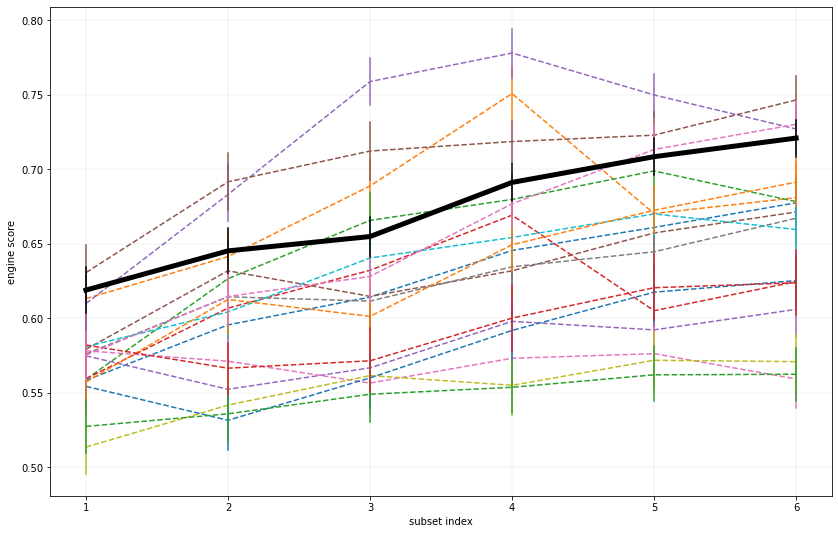

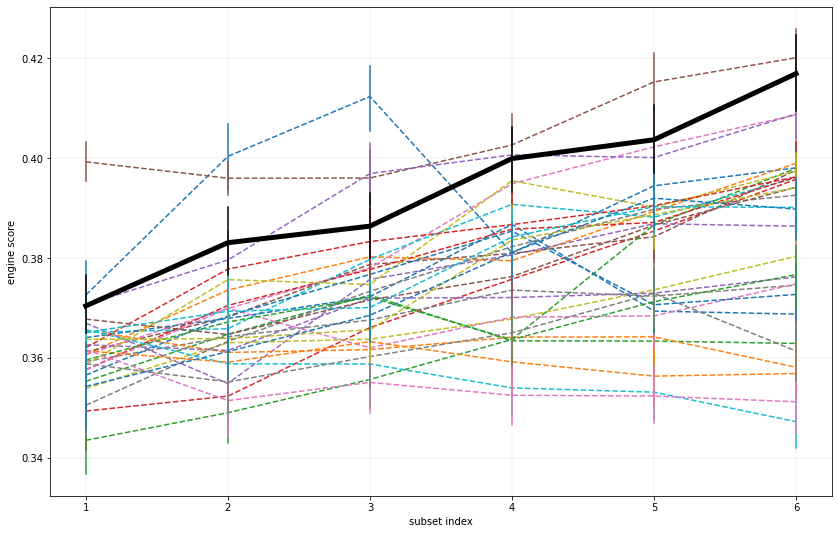

In [59]:
%matplotlib inline

engines = "TypicalityEnginev0", "PMIEnginev0"




for engine in engines:

    rng = range(1, 7)
    dist_df = [(v, k) for k in rng for v in get_samples_k(sabio_scores[engine], found, k)]
    dist_df = pd.DataFrame(dist_df, columns=["v", "k"])
    means = dist_df.groupby("k").apply(np.mean).v

    plt.figure(figsize=(14, 9))


    for c in tqdm(rand_founds.columns[:100]):
        cur_dist_df = [(v, k) for k in rng for v in get_samples_k(sabio_scores[engine],
                                                              rand_founds[c], k)]
        cur_dist_df = pd.DataFrame(cur_dist_df, columns=["v", "k"])
        cur_means = cur_dist_df.groupby("k").apply(np.mean).v

        if (cur_means - means).max() > 0.00:
            if np.max(cur_means)*0.92 > np.max(means):
                continue
            if rand.random() > 0.1:
                continue

    #     if np.max(cur_means)*1. > np.max(means):
    #         if (cur_means - means).max() > 0.1:
    #             continue
    #         if rand.random() > 0.05:
    #             continue


        sns.lineplot(data=cur_dist_df, x="k", y="v", err_style="bars",
                    linestyle="dashed")


    #     found_forms = {w for ls in rand_founds[c] for w in ls}
    #     plt.plot(cur_means, ".-", label=f"{c}, {len(found_forms)}, {rand_founds[c].apply(len).sum()}")


    sns.lineplot(data=dist_df, x="k", y="v", color="black", err_style="bars",
                linewidth=5, linestyle="solid")

    plt.xlabel("subset index")
    plt.ylabel("engine score")
    plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.2)
# plt.plot(means, "o-", c="r", label=f"CCC, {len(forms)}, {found.apply(len).sum()}", ms=10)
#
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.ylim((0.0, 1.0))

In [ ]:
for c in tqdm(rand_founds.columns):
    cur_dist_df = [(v, k) for k in rng for v in get_samples_k(sabio_scores[engine],
                                                          rand_founds[c], k)]
    cur_dist_df = pd.DataFrame(cur_dist_df, columns=["v", "k"])
    
    


In [ ]:
word_lists = rand_founds.apply(lambda col: {w for ls in col for w in ls})



---
# Checking Influence of Randomness for Subsampling 

In [ ]:
engine = "TypicalityEnginev0"
rng = range(1, 7)

plt.figure(figsize=(15, 10))

for _ in tqdm(range(10)):
    dist_df = [(v, k) for k in rng for v in get_samples_k(sabio_scores[engine], found, k)]
    dist_df = pd.DataFrame(dist_df, columns=["v", "k"])



    sns.lineplot(data=dist_df, x="k", y="v", err_style="bars")
    
plt.ylim((0., 1.))
